In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt

import time


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


plt.style.use("seaborn-v0_8-white")

#### **1. Make your Monte-Carlo efficient again: Pseudo-numbers vs Quasi-random numbers**
------

For the purpose efficient pricing of (exotic) options, we rely heavily on Monte-Carlo methods to simulate the price paths of the underlying asset based on SDE such as the Geometric Brownian Motion. 

The `NumPy` library we utilize for this purpose typically use *pseudo-random number generator* (PRNG) which is an **algorithm** that generates sequences of numbers that **appear** random, but are actually determined by an initial value called a **seed**. Despite the randomness in appearance, the sequence is entirely **deterministic** — meaning if you use the same seed, you'll always get the same sequence. In other words, although the initial seed might be generated randomly, the following sequence of numbers are  not truly random as they are completely determined by the initial value.  

The important concepts in this context are the seed and the deterministic algorithm. The seed is the starting number that initializes the PRNG. Changing the seed changes the sequence of numbers generated. The deterministic algorithm refers to a fixed mathematical formula or procedure that transforms the seed into a sequence of numbers that mimic true randomness. Furthermore, since PRNGs use finite precision, the sequence of numbers will eventually repeat. The length of time before it repeats is called the **period**. Of course, among other important properties we expect from a good PRNG algorithm to have a long period!

**A simple example of PRNG: Linear Congruential Generator**: To generate a mental map for an generic PRNG, we can consider LCG: 

$$
X_{n+1} = (a X_n + c)\quad \textrm{mod}\quad m,
$$

where $X_n$ is the current number (e.g starting from the seed $X_0$), $a,c,m$ are given constants, with modulo with respect to $m$ is introduced to keep the number within a range of values. 


#### **1.1 Generating Pseudo-Random numbers for Monte-Carlo simulations**
-----

The idea of generating pseudo-random numbers from any distribution typically starts with generating numbers from a uniform distribution, then transforming them into the desired distribution. For the purpose pricing options on underlying's that follow GBM, we are interested in generating numbers from standard normal distribution. Below we will review such common methods, that also has some historical value for generating pseudo-random numbers: 

##### **$\mathcal{N}(0,1)$ via the sum of 12 i.i.d random variables $\sim U(0,1)$**
---

In order to approximate standard normal random variables, a classic method (commonly applied in the mid 20th century) called **Irwin-Hall method** utilizes the sum of 12 independent random numbers drawn uniformly from $[0,1)$, by subtracting 6 from the resulting expression:

$$
Z = \sum_{i = 1}^{12} U_i - 6,
$$

where $U_i \sim U(0,1)$. Here, the random variable $Z$ approximates a value from standard normal distribution $\mathcal{N}(0,1)$ due to CLT. Note that the number 12 is not magic, and comes about due to statistical properties of uniform distribution: 

$$
\mathbb{E}[U_i] = \frac{1}{2},\quad\quad \mathbb{V}[U_i] = \mathbb{E}[U_i^2] - \frac{1}{4} = \frac{1}{12}
$$

which gives us the desired moments of the standard normal distribution $\mathcal{N}(\mu_Z, \sigma^2_Z)$ with $\mu_Z = 1$ and $\sigma_Z^2 = 1$. 

Implementation:

In [2]:
sample_size = 1e6
rng = np.random.default_rng(seed=42)

def irwin_hall(num_of_sample):

    return np.sum([rng.uniform(0,1,12) for i in range(int(num_of_sample))], axis = 1) - 6
    
init_time = time.time()

z_irwin_hall = irwin_hall(sample_size)

irwin_hall_time = round(time.time() - init_time,4)

print(f"Computation time with Irwin-Hall method: {irwin_hall_time}")

Computation time with Irwin-Hall method: 5.1944


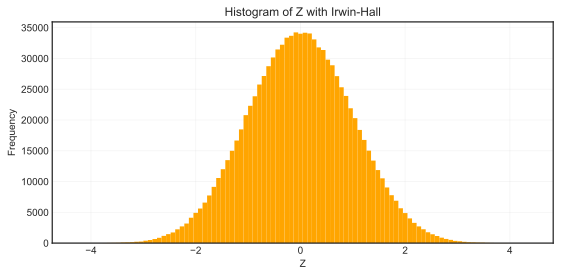

In [3]:
plt.figure(figsize = (9,4))

plt.hist(z_irwin_hall, bins = 100, color = 'orange')

plt.title('Histogram of Z with Irwin-Hall')
plt.xlabel('Z')
plt.ylabel('Frequency')
plt.grid(alpha = 0.2)

The resulting distribution seem to resemble closely a standard normal distribution. But let's check the cumulants of $Z$ to confirm. 

In [4]:
mean, std, skew, curtosis = (np.mean(z_irwin_hall), np.std(z_irwin_hall),
                             stats.skew(z_irwin_hall), stats.kurtosis(z_irwin_hall))

min, max = z_irwin_hall.min(), z_irwin_hall.max()

data = {'statistics': ['Mean', 'Std', 'Skew', 'Kurtosis', 'Min', 'Max'],
        'value': [round(mean,3), round(std,3), round(skew, 3), 
                  round(curtosis, 3), round(min,3), round(max,3)]}

describe_df = pd.DataFrame(data)

describe_df

,statistics,value
0,Mean,-0.001
1,Std,1.000
2,Skew,0.005
3,Kurtosis,-0.101
4,Min,-4.305
5,Max,4.394


Notice that Kurtosis deviates significantly from the normal distribution (which has Kurtosis 3), towards a smaller one. This is a typical situation that appear with this method which tend to have a shorter tails than the normal distribution. This situation also show itself by the min/max values which supposed to range from -6 to 6! 

Due to these limitations, **Irwin-Hall** method is rarely used in the simulation scene today! We can do better by another method called **Box-Muller** method.

##### **Box-Muller method**
----

The Box–Muller transform (method) is a classic and elegant method for generating standard normal random variables from uniformly distributed ones. It’s generally more accurate and efficient than the Irwin–Hall method, especially when high-quality normal samples are required.

It converts two independent uniform random variables into two independent standard normal random variables.

Let $U_1$ and $U_2$ be standard uniformly distributed independent random pairs, from which standard normally independent pairs can be generated via

$$
Z_1 = \sqrt{- 2 \ln U_1} \, \cos\left(2\pi\,U_2\right),\\
Z_2 = \sqrt{- 2 \ln U_1} \, \sin \left(2\pi\,U_2\right),
$$

To illustrate how Box–Muller transform actually works to give the desired outcome, we need to perform a bit of reverse engineering. First, one might wonder how $Z_1,Z_2 \sim \mathcal{N}(0,1)$ are independent when they share common factors? To see this, we can just see $Z_1,Z_2$ as Cartesian coordinates defining random variables: 

$$
R = \sqrt{- 2 \ln U_1}\quad\quad 2\pi U_2 = \theta, 
$$

which gives 

$$
\begin{align}
\nonumber Z_1 = R\, \cos\left(\Theta\right),\\
Z_2 = R\, \sin\left(\Theta\right),
\end{align}
$$

where $R \perp \Theta$ due to independence of the original uniform variables $U_1$ and $U_2$. Then the covariance of $Z_1$ and $Z_2$ can be written as 

$$
\begin{aligned}
\textrm{Cov}(Z_1,Z_2) &= \mathbb{E}[Z_1\,Z_2] - \mathbb{E}[Z_1]\, \mathbb{E}[Z_2],\\
&= \mathbb{E}[R^2 \sin(\Theta) \cos(\Theta)],\\
& = \mathbb{E}[R^2]\,\, \mathbb{E}[\sin(\Theta) \cos(\Theta)],\\
& = 0,
\end{aligned}
$$

where in the first line we used the fact the expectation of $Z$'s are vanishing, the fact that $R$ and $\Theta$ are independent and finally the vanishing of the expectation of the $\sin(\dots)\cos(\dots)$ product as they span an ortho-normal basis. In mathematical terms, noting $\Theta \sim U(0,2\pi)$ 

$$
\mathbb{E}[\sin(\Theta) \cos(\Theta)] = \frac{1}{2\pi}\int_{0}^{2\pi} \sin(\Theta) \cos(\Theta)\,\mathrm{d}\theta = 0.
$$

Having checked the independence of normal variables $Z_1$ and $Z_2$, we now return to our original quest on how the Box-Muller transform actually work? Now consider the joint distribution of the (independent) normal variables, which is also normal: 

$$
\textrm{pdf}_{Z_1,Z_2} (z_1, z_2) = \textrm{pdf}_{Z_1} \textrm{pdf}_{Z_2} = \frac{1}{2\pi}\,\mathrm{e}^{-(z_1^2 + z_2^2)/ 2}
$$

which is exactly PDF of a standard bivariate normal distribution with $\vec{\mu} = (0,0)$ and identity covariance matrix $\Sigma = \mathbb{\bf I}_{2 \times 2}$ or $(Z_1, Z_2) \sim \mathcal{N}(0,\mathbb{\bf I}_{2 \times 2})$.

Now switching to polar coordinates implied by eq. (1), we see that the joint distribution is rotationally symmetric: 

$$
\textrm{pdf}_{R,\theta}(r,\theta) = \frac{1}{2\pi}\, r\, \mathrm{e}^{-r^2/2}.
$$

More importantly, the bi-variate normal distribution factorizes into 

1. [Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution), $R \sim \textrm{Rayleigh}(\sigma = 1)$
2. Uniform distribution, $\Theta \sim U(0,2\pi)$

The question is how can we sample this joint distribution from the join distribution of two uniform variables $U_1$ and $U_2$ and if we can do that we are done! This is easy for $U_2$ as we can simply set 
$\Theta = 2\pi U_2$ as we advertised before. To get the Rayleigh distribution from the uniform $U_1$ as its generator, we then need to set the cdf of the Rayleigh to $U_1$. That is, knowing the cdf of Rayleigh distribution we can generate the distribution of $R$ using $U_1$ via 

$$
r = F_R^{-1}(u_1) \to u_1 = F_R(r) \to R = \sqrt{- 2 \ln (1 - U_1)} = \sqrt{- 2 \ln (U_1)},
$$

where we used $F_R(r) = 1 - \mathrm{e}^{-r^2/2}$.


In [5]:
def box_muller(num_samples):
    
    num_samples = int(int(num_samples)/2)
    
    u = rng.uniform(0,1,(2,num_samples)) 
    
    z_1 = np.sqrt(-2 * np.log(u[0])) * np.cos(2*np.pi*u[1])
    z_2 = np.sqrt(-2 * np.log(u[0])) * np.sin(2*np.pi*u[1])
    
    return np.concatenate((z_1,z_2))

init_time = time.time()

z_box_muller = box_muller(sample_size)
box_muller_time = round(time.time() - init_time,4)

print(f"Computation time with Box_muller method: {box_muller_time}")    

Computation time with Box_muller method: 0.0701


In [6]:
mean, std, skew, curtosis = (np.mean(z_box_muller), np.std(z_box_muller),
                             stats.skew(z_box_muller), stats.kurtosis(z_box_muller))

min, max = z_box_muller.min(), z_box_muller.max()

data = {'statistics': ['Mean', 'Std', 'Skew', 'Kurtosis', 'Min', 'Max'],
        'value': [round(mean,3), round(std,3), round(skew, 3), 
                  round(curtosis, 3), round(min,3), round(max,3)]}

describe_df = pd.DataFrame(data)

describe_df

,statistics,value
0,Mean,-0.001
1,Std,1.000
2,Skew,0.002
3,Kurtosis,-0.002
4,Min,-4.586
5,Max,5.359


We see that Box-Muller is much more efficient both from a computational perspective, as well as in terms of accuracy of the resulting normal distribution! 

#### **Inverse Transform Sampling**
-----

To understand the core idea behind this method, suppose that we want to simulate a random variable $X$ that has a known cumulative distribution function: 

$$
F(x) = \mathbb{P}(X \leq x) \in [0,1]
$$

which is continuous and strictly increasing function if $X$ has a continuous distribution (e.g it is invertible). 

Although $F$ maps a single value to another single value, we can as well consider a new random variable defined by $F(X) \equiv \bar{U}$. How is the new variable distributed? Let's compute the CDF of $U$. 

$$
\begin{aligned}
\mathbb{P}(\bar{U} \leq \bar{u}) &= \mathbb{P}(F(X) \leq \bar{u}),\\
 &= \mathbb{P}(X \leq F^{-1}(\bar{u})),\\
 & = F(F^{-1}(\bar{u})),\\
 &= \bar{u}. 
\end{aligned}
$$

However, the last relation is exactly the definition of a uniform distribution as the CDF of $U(0,1)$ read as: 

$$
\mathbb{P}(U \leq u)  = \int_{0}^{u} 1\cdot \mathrm{d}s = u.
$$

This establishes that the random variable $F(X)$ is uniformly distributed in $[0,1]$, i.e $ F(X) \sim U(0,1)$. Inverting the logic, we can generate samples of $X$ via the inverse CDF: 

$$
F^{-1}(U) \sim X
$$

and we say that the random variable $F^{-1}(U)$ has the same distribution as $X$. This is the main idea behind *inverse transform sampling*. 

For our purposes we are trying to simulate a normal variable $X$ which has a CDF of $\Phi$. 

One problem here is that there is no closed form solution for the normal CDF $\Phi$ and hence for its $\Phi^{-1}$, therefore numerical schemes has to be used. This is what the `.norm().ppf()` function does in the `scipy.stats` library!

In [13]:
def inv_xform_sampling(num_samples):
    
    u = rng.uniform(0,1,int(num_samples))
    
    return stats.norm.ppf(u)

init_time = time.time()

z_inv_samp = inv_xform_sampling(sample_size)
inv_samp_time = round(time.time() - init_time,4)

print(f"Computation time with inverse x-form sampling method: {inv_samp_time}")    

Computation time with inverse x-form sampling method: 0.1453


Notice that this method is computationally more expensive compared to the Box-Muller as `.norm().ppf()` uses some iterative algorithms under the hood. 

Unless we want to stick with Quasi-Monte Carlo methods (as we will see below for the purpose of making our MC's more efficient) to generate `.norm().ppf()` to generate normally distributed variables might not be the best choice in this sense. 

In [8]:
mean, std, skew, curtosis = (np.mean(z_inv_samp), np.std(z_inv_samp),
                             stats.skew(z_inv_samp), stats.kurtosis(z_inv_samp))

min, max = z_inv_samp.min(), z_inv_samp.max()

data = {'statistics': ['Mean', 'Std', 'Skew', 'Kurtosis', 'Min', 'Max'],
        'value': [round(mean,3), round(std,3), round(skew, 3), 
                  round(curtosis, 3), round(min,3), round(max,3)]}

describe_df = pd.DataFrame(data)

describe_df

,statistics,value
0,Mean,0.001
1,Std,1.001
2,Skew,-0.000
3,Kurtosis,-0.009
4,Min,-4.772
5,Max,4.702


Although, it might not be the first choice in terms of computational speed, inverse sampling method essentially give rise to an accurate normal distribution!

Of course when we deal with simulating simple distributions like normal distribution we do not have to rely on the methods above, as `numpy` have built in methods that does the job quite efficient way getting help from C libraries and algorithms like Ziggurat method!

In [10]:
init_time = time.time()

z_numpy = rng.normal(0,1,int(sample_size))

numpy_time = round(time.time() - init_time,4)

print(f"Computation time with NumPy: {numpy_time}")    


Computation time with NumPy: 0.0451


In [12]:
mean, std, skew, curtosis = (np.mean(z_numpy), np.std(z_numpy),
                             stats.skew(z_numpy), stats.kurtosis(z_numpy))

min, max = z_numpy.min(), z_numpy.max()

data = {'statistics': ['Mean', 'Std', 'Skew', 'Kurtosis', 'Min', 'Max'],
        'value': [round(mean,3), round(std,3), round(skew, 3), 
                  round(curtosis, 3), round(min,3), round(max,3)]}

describe_df = pd.DataFrame(data)

describe_df

,statistics,value
0,Mean,-0.002
1,Std,1.000
2,Skew,0.001
3,Kurtosis,0.004
4,Min,-5.107
5,Max,5.001


#### Why pseudo-random numbers could be bad for your MC simulation
-----

Apart from the fact that they are seeded and thus the subsequent sequence has non-random properties, it turns out that the use of pseudo-random numbers is bad for your MC simulation from a computational efficiency perspective. Remember, when we want to simulate multi-dimensional problems, MC simulations tend to become time consuming at a desired accuracy level, so the whole point is to keep the accuracy at bay while reducing the computation time. 

To illustrate this, consider two independent random samples drawn from the Uniform distribution:


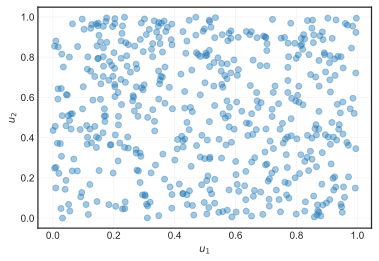

In [30]:
samp_size = 500

u_1 = rng.uniform(0,1,samp_size)
u_2 = rng.uniform(0,1,samp_size)

fig, axes = plt.subplots(figsize = (6,4))

axes.scatter(u_1,u_2, marker = 'o', alpha = 0.4)

axes.set_xlabel(r'$u_1$')
axes.set_ylabel(r'$u_2$')

axes.grid(alpha = 0.2)

As the random variables are i.i.d, every point in the 2D plane is equally likely, however we can clearly see clumps, as well as voids as a result. 

If we increase the sampling points sufficiently, then this structure will diminish, as the large number of points we sample will clutter each point on the graph, improving the uniformity. 

The goal in MC simulations is however to improve the computation time as with all variance reduction techniques without increasing the number of simulations! 

We can say that pseudo-random numbers introduce a bias, and tend to generate similar numbers leading clumpy structures!  

#### **Quasi-Random numbers**
-----

As opposed to pseudo-random numbers, quasi-random numbers are designed to appear random and fill a space more evenly than the former. They are often referred as low-discrepency sequences. In essence, the next generated quasi-random samples are not independent form the previous one, in order to prevent lumpiness, i.e. each number generated remembers the previous ones and try to position itself away from the previous sequence. In this sense, they can be considered more *deterministic* than the pseudo-random numbers! 

There are many algorithms that are used as a Quasi-random number generator (QRNG), some notable ones are 

- Faure sequence
- Haselgrove sequence
- Halton sequence
- Sobol sequence

We will focus on the last two as they can be readily implemented by `SciPy`! First visualize the less clumpy structures generated by them!

In [24]:
from scipy.stats import qmc

def halton_seq(num_of_samples, d = 1):
    '''
    d: dimensionality
    '''
    halton_sampler = qmc.Halton(d, scramble=True) 
    
    return halton_sampler.random(num_of_samples)

def sobol_seq(p, d = 1):
    '''
    p: we can only generate 2^{p} samples with this method
    '''
    sobol_sampler = qmc.Sobol(d, scramble=True) 
    
    return sobol_sampler.random_base2(p)

Let's see how well they mimic a Uniform distribution.

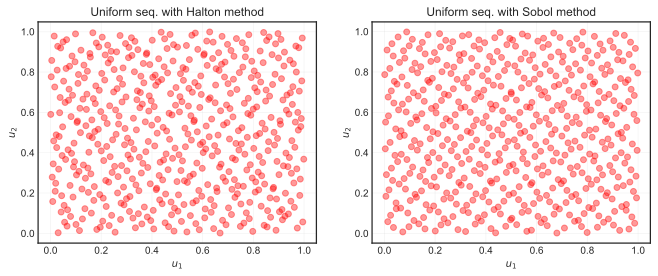

In [28]:
fig, axes = plt.subplots(1,2,figsize = (11,4))

u_sobol = sobol_seq(9,d=2).T
u_halton = halton_seq(500, d=2).T

axes[0].scatter(u_halton[0],u_halton[1], color= 'red', marker = 'o', alpha = 0.4)
axes[1].scatter(u_sobol[0],u_sobol[1], color= 'red', marker = 'o', alpha = 0.4)

for idx, method in enumerate(['Halton', 'Sobol']):
    
    axes[idx].set_title(f'Uniform seq. with {method} method')
    axes[idx].set_xlabel(r'$u_1$')
    axes[idx].set_ylabel(r'$u_2$')
    axes[idx].grid(alpha = 0.2)

Clearly, uniformity is more prominent as compared to our previous results based on pseudo-random numbers.

Finally, we will test the perks of working with Quasi-random numbers as compared to their pseudo counterpart in the context of computational efficiency for option pricing. To illustrate these ideas, we will focus on European Vanilla options that have a known analytic solution within the Black Scholes world. 

#### **Monte-Carlo convergence rates: Quasi vs Pseudo-random number Generators**
------

In [36]:
from scipy.stats import norm
# contract details for a fiducial option

r = 0.0265 # Risk-free rate
S_in = 100 # current stock price
K = 102 # strike
T = 240/365 # maturity
vol = 0.2 # volatility

def black_scholes_price(S, K, T, r, sigma, type='c'):
    """
    Compute the Black-Scholes price for a European option.
    
    Parameters:
    -----------
    S : float or np.ndarray
        Current stock price
    K : float or np.ndarray
        Strike price
    T : float or np.ndarray
        Time to maturity in years
    r : float
        Risk-free interest rate (annualized)
    sigma : float or np.ndarray
        Volatility of the underlying asset (annualized)
    type : str
        'c' for a call option, 'p' for a put option
    
    Returns:
    --------
    price : float or np.ndarray
        The option price
    """
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    sigma = np.asarray(sigma)
    
    # Handle the edge case where T = 0, to avoid division by zero
    intrinsic_value = np.where(type == 'c',
                               np.maximum(S - K, 0),
                               np.maximum(K - S, 0))
    
    epsilon = 1e-10
    denom = sigma * np.sqrt(T)
    denom = np.where(denom == 0, epsilon, denom)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / denom
    d2 = d1 - denom

    if type == 'c':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'p':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Please confirm option type: 'type' must be 'call' or 'put'")

    return np.where(T == 0, intrinsic_value, price)

bs_price = black_scholes_price(S_in, K, T, r, vol)

print(f"Black-Scholes price of the option is {bs_price:.3f}")

Black-Scholes price of the option is 6.352


We first define two functions that produces samples from standard normal using Halton and Sobol sequences.

In [45]:
def halton_seq_to_norm(num_of_samples, d = 1):
    
    halton_sampler = qmc.Halton(d, scramble=True)
    
    # halton sequence mimicking a uniform sample
    u_halton = halton_sampler.random(num_of_samples)
    
    # inverse transform sampling to get back to normal
    return stats.norm.ppf(u_halton)


def sobol_seq_to_norm(p, d = 1):
    
    sobol_sampler = qmc.Sobol(d, scramble=True)
    
    # halton sequence mimicking a uniform sample
    u_sobol = sobol_sampler.random_base2(p)
    
    # inverse transform sampling to get back to normal
    return stats.norm.ppf(u_sobol)

Now we define some dictionaries to store the results for each method we will utilize: 

- For Pseudo-random numbers 
  
  1. Irwin-Hall
  2. Box-Muller
  3. Inverse transform sampling
  
- For Quasi-random numbers
  
  1. Halton
  2. Sobol

In [100]:
results_dict = {'pseudo: irwin_hall': [],
           'pseudo: box_muller': [],
           'pseudo: inverse_sampling': [],
           'quasi : halton': [],
           'quasi : sobol': []
           }

generator_dicts = {'pseudo: irwin_hall': irwin_hall,
           'pseudo: box_muller': box_muller,
           'pseudo: inverse_sampling': inv_xform_sampling,
           'quasi : halton': halton_seq_to_norm,
           'quasi : sobol': sobol_seq_to_norm
           }

In [101]:
N = 1 # path independent option, so we only focus on simulating numbers at the expiry
dt = T/N
mudt = (r - 0.5 * vol**2) * dt 
voldt = vol * np.sqrt(dt)
lnS0 = np.log(S_in)

num_of_sims_list = np.array([i for i in range(250,4000,250)])

for sim_num in num_of_sims_list:
    
    for method in results_dict.keys():
        
        if method != 'quasi : sobol':
            
            Z = generator_dicts[method](sim_num)
            
            delta_lnSt = mudt + voldt * Z # for N = 1, gives ln S_T
            S_T = S_in*np.exp(delta_lnSt)
            C_T = np.maximum(0, S_T - K)
            C_0 = np.exp(-r*T)*np.sum(C_T)/(sim_num)
            results_dict[method].append((C_0/bs_price - 1) * 100) # percent error
            
# we deal with sobol results differently, as the num of sims should be 2**p            
sobol_rng = np.arange(8,13)

for p in sobol_rng:
    
    Z = generator_dicts['quasi : sobol'](p)
    delta_lnSt = mudt + voldt*Z
    ST = S_in*np.exp(delta_lnSt)
    CT = np.maximum(0, ST - K)
    C0 = np.exp(-r*T)*np.sum(CT)/(2**p)

    results_dict['quasi : sobol'].append((C_0/bs_price - 1) * 100)



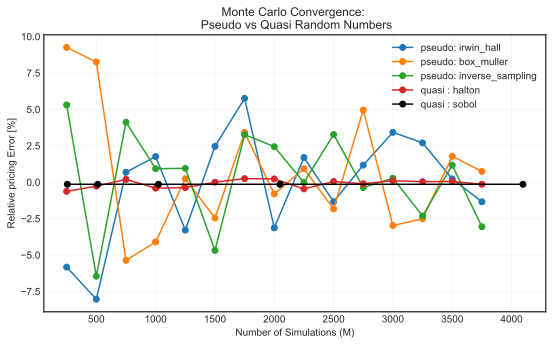

In [104]:
plt.figure(figsize = (9,5))

for method in results_dict:
    if method == 'quasi : sobol':
        plt.plot(2**sobol_rng,results_dict[method],label=method,color='k',marker='o')
    else:
        plt.plot(num_of_sims_list,results_dict[method],label=method,marker='o')

plt.legend()
plt.title('Monte Carlo Convergence: \n Pseudo vs Quasi Random Numbers')
plt.ylabel('Relative pricing Error [%]')
plt.xlabel('Number of Simulations (M)')
plt.grid(alpha = 0.2)

Notice how quickly the MC simulations utilizing halton and sobol sequences converge to the correct Black-Scholes price as compared to the methods utilizing pseudo-random number generators.